# 뉴스 카테고리 다중분류 프로젝트
#### 주제
- Vocabulary Size 변경해서 시도해보기
    1. 모든 단어 사용
    2. 빈도수 상위 5000개의 단어만 사용
    3. 직접 단어 개수 설정해서 사용 
- 모델 3가지 이상 사용: SVC, LinearRegression, RandomForest, Voting
    - RNN, 1-D CNN 등 딥러닝 모델 중 하나 선택해서 머신러닝과 결과 비교하기

In [1]:
from tensorflow.keras.datasets import reuters

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [107]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# 1.모든 단어 사용하기

## 1-1. 데이터 로드 및 벡터화

In [4]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [10]:
def check_data(x_train, y_train, x_test, y_test):
    # 훈련 및 테스트 샘플 수 확인
    print('훈련 샘플의 수: {}'.format(len(x_train)))
    print('테스트 샘플의 수: {}'.format(len(x_test)))
    
    # 클래스 수 확인
    num_classes = max(y_train) + 1
    print('클래스의 수 : {}'.format(num_classes))
    
    # 훈련 데이터 최대 길이 및 평균 길이 확인
    print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
    print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))
    
    plt.subplot(211)
    plt.hist([len(s) for s in x_train], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.title("Length Distribution")
    
    # 각 클래스 빈도수 확인
    plt.subplot(212)
    sns.countplot(x=y_train)
    plt.title("Frequency of classes")
    plt.show()

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246
클래스의 수 : 46
훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


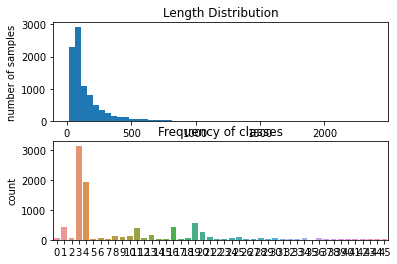

In [11]:
check_data(x_train, y_train, x_test, y_test)

In [45]:
def vectorize(x_train, x_test):
    # vocab 만들기
    word_index = reuters.get_word_index(path = "reuters_word_index.json")
    index_to_word = {index + 3 : word for word, index in word_index.items()}
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
        index_to_word[index] = token
    
    # index -> 원문 text 복원하기
    x_train_decoded = []
    for i in range(len(x_train)):
        t = ' '.join([index_to_word[index] for index in x_train[i]])
        x_train_decoded.append(t)
    
    x_test_decoded = []
    for i in range(len(x_test)):
        t = ' '.join([index_to_word[index] for index in x_test[i]])
        x_test_decoded.append(t)
    
    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(x_train_decoded)
    x_test_dtm = dtmvector.transform(x_test_decoded)
    
    tfidf_transformer = TfidfTransformer()
    x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
    x_test_tfidf = tfidf_transformer.transform(x_test_dtm)
    
    return x_train_tfidf, x_test_tfidf, x_train_decoded, x_test_decoded, word_index, index_to_word

In [46]:
x_train_tfidf, x_test_tfidf, x_train_decoded, x_test_decoded, word_index, index_to_word = vectorize(x_train, x_test)

In [20]:
x_train_tfidf.shape

(8982, 26506)

In [21]:
x_test_tfidf.shape

(2246, 26506)

## 1-2. 머신러닝 모델 학습하기

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier

In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### LogisticRegression

In [26]:
start_time = time.time()
lr = LogisticRegression(C=10000, penalty = "l2", max_iter = 3000)
lr.fit(x_train_tfidf, y_train)
end_time = time.time()
learning_time_lr = end_time - start_time 

print(f"training time for logistic regression:{learning_time_lr: .2f} 초")

training time for logistic regression: 879.21 초


In [108]:
predicted = lr.predict(x_test_tfidf)
acc_lr = accuracy_score(y_test, predicted)
f1_lr = f1_score(y_test, predicted, average = 'weighted')
print("정확도: ", acc_lr)
print("f1-score:", f1_lr)
print(classification_report(y_test, predicted, zero_division = 0))

정확도:  0.8165627782724845
f1-score: 0.8114428402876209
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.75      0.79      0.77       105
           2       0.78      0.70      0.74        20
           3       0.92      0.93      0.93       813
           4       0.81      0.88      0.84       474
           5       1.00      0.20      0.33         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.69      0.71      0.70        38
           9       0.85      0.88      0.86        25
          10       0.93      0.90      0.92        30
          11       0.67      0.72      0.69        83
          12       0.57      0.31      0.40        13
          13       0.64      0.62      0.63        37
          14       0.67      1.00      0.80         2
          15       0.80      0.44      0.57         9
          16       0.71    

### RandomForest

In [28]:
start_time = time.time()
rf = RandomForestClassifier(n_estimators = 5, random_state = 0)
rf.fit(x_train_tfidf, y_train)
end_time = time.time()
learning_time_rf = end_time - start_time 

print(f"training time for RandomForest:{learning_time_rf: .2f} 초")

training time for RandomForest: 2.14 초


In [109]:
predicted = rf.predict(x_test_tfidf)
acc_rf = accuracy_score(y_test, predicted)
f1_rf = f1_score(y_test, predicted, average = 'weighted')
print("정확도:", acc_rf) 
print("f1-score:", f1_rf)
print(classification_report(y_test, predicted, zero_division = 0))

정확도: 0.6544968833481746
f1-score: 0.6225909375608356
              precision    recall  f1-score   support

           0       0.25      0.58      0.35        12
           1       0.35      0.60      0.44       105
           2       0.32      0.40      0.36        20
           3       0.82      0.89      0.85       813
           4       0.62      0.84      0.71       474
           5       0.00      0.00      0.00         5
           6       0.67      0.43      0.52        14
           7       0.50      0.33      0.40         3
           8       0.51      0.47      0.49        38
           9       1.00      0.28      0.44        25
          10       0.46      0.20      0.28        30
          11       0.56      0.64      0.60        83
          12       0.40      0.15      0.22        13
          13       0.33      0.16      0.22        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.59     

### linearSVC -> Soft-voting 적용 불가 (predict_proba 미제공)

In [31]:
start_time = time.time()
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(x_train_tfidf, y_train)
end_time = time.time()
learning_time_svc = end_time - start_time

print(f"training time for SVC:{learning_time_svc: .2f} 초")

training time for SVC: 104.05 초


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [99]:
predicted = lsvc.predict(x_test_tfidf)
acc_svc = accuracy_score(y_test, predicted)
print("정확도: ", acc_svc)

NotFittedError: This LinearSVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### CalibratedClassifierCV 적용 

In [41]:
from sklearn.calibration import CalibratedClassifierCV

start_time = time.time()
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
calibrated_model = CalibratedClassifierCV(lsvc, cv = 5)
calibrated_model.fit(x_train_tfidf, y_train)
end_time = time.time()
learning_time_ccsvc = end_time - start_time

print(f"training time for CalibratedSVC:{learning_time_ccsvc: .2f} 초")

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


training time for CalibratedSVC: 397.05 초


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [112]:
predicted = calibrated_model.predict(x_test_tfidf)
acc_ccsvc = accuracy_score(y_test, predicted)
f1_ccsv = f1_score(y_test, predicted, average = 'weighted')
print("정확도: ", acc_ccsvc)
print("f1-score: ", f1_ccsv)
print(classification_report(y_test, predicted, zero_division = 0))

정확도:  0.7991985752448798
f1-score:  0.7897576909777327
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.75      0.75      0.75       105
           2       0.68      0.75      0.71        20
           3       0.89      0.94      0.91       813
           4       0.78      0.88      0.83       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.33      0.50         3
           8       0.65      0.68      0.67        38
           9       0.91      0.80      0.85        25
          10       0.96      0.83      0.89        30
          11       0.66      0.73      0.70        83
          12       0.50      0.31      0.38        13
          13       0.64      0.57      0.60        37
          14       1.00      1.00      1.00         2
          15       0.67      0.22      0.33         9
          16       0.70   

### Voting

In [43]:
start_time = time.time()
voting_classifier = VotingClassifier(
    estimators = [
    ('lr', lr), ('rf', rf), ('ccsvc', calibrated_model)],
    voting = 'soft'
)
voting_classifier.fit(x_train_tfidf, y_train)
end_time = time.time()
learning_time_voting = end_time - start_time

print(f"training time for SVC:{learning_time_voting: .2f} 초")

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


training time for SVC: 1232.88 초


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [114]:
predicted = voting_classifier.predict(x_test_tfidf)
acc_voting = accuracy_score(y_test, predicted)
f1_voting = f1_score(y_test, predicted, average = 'weighted')
print("정확도: ", acc_voting)
print("f1-score: ", f1_voting)
print(classification_report(y_test, predicted, zero_division = 0))

정확도:  0.8143365983971504
f1-score:  0.8074185434484336
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.74      0.80      0.77       105
           2       0.74      0.70      0.72        20
           3       0.91      0.93      0.92       813
           4       0.79      0.88      0.84       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.70      0.74      0.72        38
           9       0.85      0.88      0.86        25
          10       0.93      0.87      0.90        30
          11       0.65      0.75      0.70        83
          12       0.57      0.31      0.40        13
          13       0.66      0.62      0.64        37
          14       0.50      0.50      0.50         2
          15       0.80      0.44      0.57         9
          16       0.70   

### DeepLearning - LSTM
1. x_train, x_test 그대로 사용
    - 로이터 데이터는 load할 때, num_words가 넘는 단어는 자동으로 <unk> 토큰 처리함
2. sequence_length 비교 후 max_length 지정
3. padding 토큰 추가 

In [47]:
x_train[0], x_test[0]

([1,
  27595,
  28842,
  8,
  43,
  10,
  447,
  5,
  25,
  207,
  270,
  5,
  3095,
  111,
  16,
  369,
  186,
  90,
  67,
  7,
  89,
  5,
  19,
  102,
  6,
  19,
  124,
  15,
  90,
  67,
  84,
  22,
  482,
  26,
  7,
  48,
  4,
  49,
  8,
  864,
  39,
  209,
  154,
  6,
  151,
  6,
  83,
  11,
  15,
  22,
  155,
  11,
  15,
  7,
  48,
  9,
  4579,
  1005,
  504,
  6,
  258,
  6,
  272,
  11,
  15,
  22,
  134,
  44,
  11,
  15,
  16,
  8,
  197,
  1245,
  90,
  67,
  52,
  29,
  209,
  30,
  32,
  132,
  6,
  109,
  15,
  17,
  12],
 [1,
  4,
  1378,
  2025,
  9,
  697,
  4622,
  111,
  8,
  25,
  109,
  29,
  3650,
  11,
  150,
  244,
  364,
  33,
  30,
  30,
  1398,
  333,
  6,
  18292,
  159,
  9,
  1084,
  363,
  13,
  19231,
  71,
  9,
  16273,
  71,
  117,
  4,
  225,
  78,
  206,
  10,
  9,
  1214,
  8,
  4,
  270,
  5,
  16273,
  7,
  748,
  48,
  9,
  19231,
  7,
  207,
  1451,
  966,
  1864,
  793,
  97,
  133,
  336,
  7,
  4,
  493,
  98,
  273,
  104,
  284,
  25,
  39,


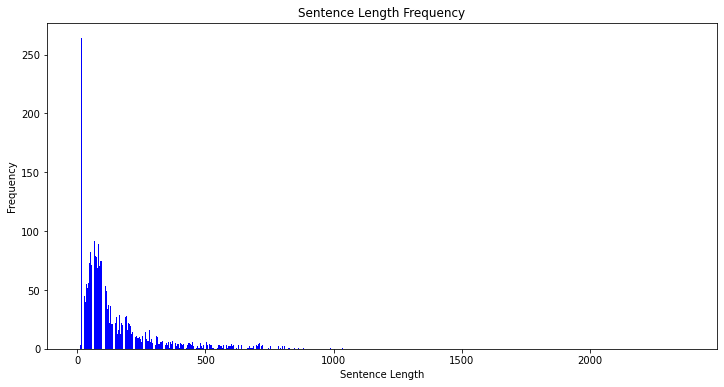

In [51]:
from collections import Counter

data = list(x_train) + list(x_test)
num_tokens = [len(index_list) for index_list in data]

tokens_counts = Counter(num_tokens)
lengths = sorted(tokens_counts.keys())
frequencies = [tokens_counts[length] for length in lengths]

plt.figure(figsize = (12, 6))
plt.bar(lengths, frequencies, color = 'blue')
plt.title("Sentence Length Frequency")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.show()

In [52]:
print("min length :", np.min(num_tokens))
print("max length :", np.max(num_tokens))
print("avg length :", np.average(num_tokens))
print("median length :", np.median(num_tokens))

min length : 2
max length : 2376
avg length : 145.96419665122906
median length : 95.0


In [62]:
# 하위 length 길이 확인
lengths[:10]

[2, 13, 15, 16, 17, 18, 19, 20, 21, 22]

In [53]:
# 평균 + 2*표준편차
np.average(num_tokens) + 2*np.std(num_tokens)

437.7211495431185

In [61]:
minlen = 10
maxlen = 440

valid_cnt = len([length for length in num_tokens if minlen <= length <= maxlen])
print(f'''minlen: {minlen}
maxlen: {maxlen}
valid %:{valid_cnt/len(num_tokens)*100: .2f}% ''')

minlen: 10
maxlen: 440
valid %: 94.43% 


In [76]:
# x_train에서 토큰 개수 2이하인 데이터 삭제, max_length = 440 지정하여 패딩처리
print("원본 x_train 개수: ", len(x_train))
x_train = [index_list for index_list in x_train if len(index_list) > 3]
print("토큰개수 2 이하 시퀀스 삭제 후 x_train 개수: ", len(x_train))

원본 x_train 개수:  8982
토큰개수 2 이하 시퀀스 삭제 후 x_train 개수:  8982


- x_train에는 2이하의 토큰이 없었던 것 같다!
- 2 이하의 시퀀스는 test 데이터셋에만 포함된 듯

**최소 길이 데이터셋 확인**

In [80]:
x_test_tmp = [index_list for index_list in x_test if len(index_list) <= 2]
len(x_test_tmp)

1

In [81]:
frequencies[0]

1

**패딩 추가**

In [82]:
# index_to_word 사용해서 word_to_index 만들기
word_to_index = {word:index for index, word in index_to_word.items()}

In [83]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, value = word_to_index["<pad>"], padding = 'pre', maxlen = maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, value = word_to_index["<pad>"], padding = 'pre', maxlen = maxlen)

**train, val 데이터셋 나누기**

In [86]:
from sklearn.model_selection import train_test_split

x_train_partial, x_val, y_train_partial, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 2024)
x_train_partial.shape, y_train_partial.shape, x_val.shape, y_val.shape

((7185, 440), (7185,), (1797, 440), (1797,))

### 모델 정의하기

In [88]:
# 레이블 개수
np.max(y_train)+1

46

In [89]:
vocab_size = len(word_to_index)
word_vector_dim = 128

model_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape = (None, )),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(46, activation = "softmax")
])

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         3965696   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 46)                2990      
Total params: 4,108,526
Trainable params: 4,108,526
Non-trainable params: 0
_________________________________________________________________


In [90]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best_model_rnn.keras", monitor = "val_accuracy", verbose = 1, save_best_only = True)

In [93]:
model_rnn.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
history_rnn = model_rnn.fit(x_train_partial, 
                            y_train_partial, 
                            epochs = 100, 
                            batch_size = 512,
                            validation_data = (x_val, y_val),
                            callbacks = [checkpoint])

Epoch 1/100
15/15 [==============================] - 39s 203ms/step - loss: 3.5819 - accuracy: 0.3240 - val_loss: 2.9010 - val_accuracy: 0.3589

Epoch 00001: val_accuracy improved from -inf to 0.35893, saving model to best_model_rnn.keras
Epoch 2/100
15/15 [==============================] - 2s 110ms/step - loss: 2.7207 - accuracy: 0.3094 - val_loss: 2.5709 - val_accuracy: 0.3589

Epoch 00002: val_accuracy did not improve from 0.35893
Epoch 3/100
15/15 [==============================] - 2s 102ms/step - loss: 2.4025 - accuracy: 0.3587 - val_loss: 2.2421 - val_accuracy: 0.4079

Epoch 00003: val_accuracy improved from 0.35893 to 0.40790, saving model to best_model_rnn.keras
Epoch 4/100
15/15 [==============================] - 2s 105ms/step - loss: 2.0827 - accuracy: 0.4029 - val_loss: 2.0258 - val_accuracy: 0.4213

Epoch 00004: val_accuracy improved from 0.40790 to 0.42126, saving model to best_model_rnn.keras
Epoch 5/100
15/15 [==============================] - 2s 108ms/step - loss: 1.889

In [104]:
from tensorflow.keras.models import load_model

model_rnn = load_model("best_model_rnn.keras")
results_rnn = model_rnn.evaluate(x_test, y_test, verbose = 2)

71/71 - 1s - loss: 3.3976 - accuracy: 0.5788


In [105]:
predicted = model_rnn.predict(x_test)
predicted_classes = np.argmax(predicted, axis = 1)
print(classification_report(y_test, predicted_classes, zero_division = 0))

              precision    recall  f1-score   support

           0       0.29      0.17      0.21        12
           1       0.41      0.30      0.35       105
           2       0.18      0.15      0.16        20
           3       0.92      0.88      0.90       813
           4       0.68      0.82      0.74       474
           5       0.07      0.20      0.11         5
           6       0.75      0.21      0.33        14
           7       0.50      0.33      0.40         3
           8       0.14      0.24      0.18        38
           9       0.33      0.12      0.18        25
          10       0.12      0.07      0.09        30
          11       0.20      0.24      0.22        83
          12       0.11      0.15      0.13        13
          13       0.07      0.08      0.07        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.25      0.21      0.23        99
          17       0.04    